`indices_oni_1.ncl`: NOAA's operational definitions of El Niño and La Niña conditions are based upon the Oceanic Niño Index [ONI]. The ONI is defined as the 3-month running means of SST anomalies in the Niño 3.4 region [5N-5S, 120-170W]. The anomalies are derived from the 1971-2000 SST climatology.
The Niño 3.4 anomalies may be thought of as representing the average equatorial SSTs across the Pacific from about the dateline to the South American coast. To be classified as a full-fledged El Niño and La Niña episode the ONI must exceed +0.5 [El Niño] or -0.5 [La Niña] for at least five consecutive months.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt

In [4]:
import numpy as np

In [3]:
# Just for fun, let's define a version of printVarSummary:
# same as in indices_nino_1.ipynb
def printVarSummary(da):
    n = da.name
    if hasattr(da, 'units'):
        u = da.units
    else:
        u = None
    if hasattr(da, 'long_name'):
        lng = da.long_name
    else:
        lng = "NO LONG NAME"
    c = []
    for i in da.dims:
        if i in da.coords:
            c.append(f"\t dim: {i} with coordinate of shape {da.coords[i].shape}")
        else:
            c.append(f"\t dim: {i} with no coordinate variable")
    mn = da.min().values.item()
    mx = da.max().values.item()
    print(f"{n} ({u})\n  {lng}\n  minimum: {mn}\n  maximum: {mx}")
    for i in c:
        print(i)



In [36]:
#----------------------------------------------------------------------
# indices_oni_1.ncl
#
# Concepts illustrated:
#   - Computing the Oceanic Nino Index
#   - Drawing a time series plot
#----------------------------------------------------------------------
#
# These files are loaded by default in NCL V6.2.0 and newer
# load "$NCARG_ROOT/lib/ncarg/nclscripts/csm/gsn_code.ncl"
# load "$NCARG_ROOT/lib/ncarg/nclscripts/csm/gsn_csm.ncl" 
# load "$NCARG_ROOT/lib/ncarg/nclscripts/csm/contributed.ncl" 
#---------------------------------------------------------------------------
# NOAA's operational definitions of El Niño and La Niña conditions are based
# upon the Oceanic Niño Index [ONI]. The ONI is defined as the 3-month running
# means of SST anomalies in the Niño 3.4 region [5N-5S, 120-170W]. The anomalies
# are derived from the 1971-2000 SST climatology.
#
# The Niño 3.4 anomalies may be thought of as representing the average equatorial
# SSTs across the Pacific from about the dateline to the South American coast.
# To be classified as a full-fledged El Niño and La Niña episode the ONI must excee
# d +0.5 [El Niño] or -0.5 [La Niña] for at least five consecutive months. 
#---------------------------------------------------------------------------
#                         User input
#---------------------------------------------------------------------------
latS   = -5.0
latN   =  5.0
lonL   = 190.0
lonR   = 240.0

nrun   = 3             # length of running average

ymStrt = 187001
ymLast = 201112        # last full year on file

clStrt = 197101        # climatology start    
clLast = 200012        #             last

yrStrt = ymStrt // 100  # NOTE: integer division
yrLast = ymLast // 100

pltType = "png"       # send graphics to PNG file
pltDir  = "./"        # dir to which plots are sent
#pltName = "ONI."+(ymStrt/100)+"-"+(ymLast/100)
pltName = "indices_oni"

pltTitle= "ONI: "+str(ymStrt//100)+"-"+str(ymLast//100) \
      + ": Base "+str(clStrt//100)+"-"+str(clLast//100)  # NOTE: this isn't my first choice for formatting, but just to show it works.

#-------------------- End User Input ---------------------------------------


In NCL (and many languages), you need to deal with getting the integer indices of arrays to select the correct sub-array. NCL is amazing that the `{}` notation can be used with coordinate array indexing. When using python in general, and numpy and xarray in particular, it is often a red flag if you find yourself really struggling to get indices of some value. In the next cell, the NCL example goes to some effort to deal with dates as integer values (`YYYYMM`). I am going to show how to do the same operations both with finding indices and using them, and also using coordinate slicing. The coordinate slicing works here because the time dimension is perfectly well-suited to selecting the range of time specified as `YYYY-MM-DD` strings. 

In [32]:
ds = xr.open_dataset("/Users/brianpm/Downloads/MODEL.SST.HAD187001-198110.OI198111-201203.nc")
# x = ds['SST'].sel(lat=slice(latS, latN), lon=slice(lonL, lonR))

YYYYMM= (ds['date']) // 100  # ALL dates on file; note: integer division
# just to show how to get these indices if you really need to:
# NOTE: have to use `.values` because we need to convert to plain numpy array
# NOTE: argwhere returns an array, so use `item()` to convert to a scalar
tStrt = np.argwhere(YYYYMM.values == ymStrt).item()      # indices of selected times
tLast = np.argwhere(YYYYMM.values == ymLast).item()
print(f"The  start is {ymStrt} at index {tStrt}. The ending is {ymLast} at index {tLast}.")
# NOTE: WARNING! python indexing inclusive on the beginning index and exclusive on the ending,
# so you need to add 1 in this incantation
x = ds['SST'].isel(time=slice(tStrt,tLast+1)).sel(lat=slice(latS,latN), lon=slice(lonL,lonR))
printVarSummary(x)  # use our custom function (defined above)

xalt = ds['SST'].sel(time=slice(f"{yrStrt}-01-01",f"{yrLast}-12-31"), lat=slice(latS,latN), lon=slice(lonL,lonR))
printVarSummary(xalt)

date = ds['date'][tStrt:tLast+1]  # remember to add 1
printVarSummary(date)
yyyymm = date // 100
ntim = len(date)
print(f"Length of the date variable is {ntim}")
#*********************************
# time indices for base climatology 
#*********************************

iClmStrt = np.argwhere(yyyymm.values == clStrt).item()   
iClmLast = np.argwhere(yyyymm.values == clLast).item()
#print(date(iClmStrt:iClmLast))


The  start is 187001 at index 0. The ending is 201112 at index 1703.
SST (degC)
  Sea Surface Temperature
  minimum: 20.400646209716797
  maximum: 30.750333786010742
	 dim: time with coordinate of shape (1704,)
	 dim: lat with coordinate of shape (10,)
	 dim: lon with coordinate of shape (50,)
SST (degC)
  Sea Surface Temperature
  minimum: 20.400646209716797
  maximum: 30.750333786010742
	 dim: time with coordinate of shape (1704,)
	 dim: lat with coordinate of shape (10,)
	 dim: lon with coordinate of shape (50,)
date (yyyymmdd)
  NO LONG NAME
  minimum: 18700116
  maximum: 20111216
	 dim: time with coordinate of shape (1704,)
Length of the date variable is 1704


In [33]:
#*********************************
# Climatology and anomalies from base climatology   
#*********************************

xClm = x[iClmStrt:iClmLast+1,:,:].groupby('time.month').mean(dim='time') # Direct indexing just like NCL; clmMonTLL(x(iClmStrt:iClmLast,:,:))
printVarSummary(xClm)

xClmAlt = x.sel(time=slice('1971-01-01', '2000-12-31')).groupby('time.month').mean(dim='time')
printVarSummary(xClmAlt)

xAnom = x.groupby('time.month') - xClmAlt  # calcMonAnomTLL (x,  xClm ) 
xAnom.attrs['long_name'] = "SST Anomalies"
printVarSummary(xAnom)

#*********************************
# Unweighted areal average anomalies (time series)
# Small latitudinal extent so no need to weight    
#*********************************

xAnom_avg = xAnom.mean(dim=('lon','lat'))
xAnom_avg.attrs['long_name'] = "areal avg anomalies"
printVarSummary(xAnom_avg)

#*********************************
# Perform an unweighted 'nrun' month running average
#*********************************

xAnom_avg = xAnom_avg.rolling(time=nrun).mean()
printVarSummary(xAnom_avg)

SST (None)
  NO LONG NAME
  minimum: 23.790515899658203
  maximum: 29.223142623901367
	 dim: month with coordinate of shape (12,)
	 dim: lat with coordinate of shape (10,)
	 dim: lon with coordinate of shape (50,)
SST (None)
  NO LONG NAME
  minimum: 23.790515899658203
  maximum: 29.223142623901367
	 dim: month with coordinate of shape (12,)
	 dim: lat with coordinate of shape (10,)
	 dim: lon with coordinate of shape (50,)
SST (None)
  SST Anomalies
  minimum: -3.970794677734375
  maximum: 5.497858047485352
	 dim: time with coordinate of shape (1704,)
	 dim: lat with coordinate of shape (10,)
	 dim: lon with coordinate of shape (50,)
SST (None)
  areal avg anomalies
  minimum: -2.425320863723755
  maximum: 2.8526532649993896
	 dim: time with coordinate of shape (1704,)
None (None)
  NO LONG NAME
  minimum: -2.1479620933532715
  maximum: 2.7153518199920654
	 dim: time with coordinate of shape (1704,)


Text(0.5, 1.0, 'ONI: 1870-2011: Base 1971-2000')

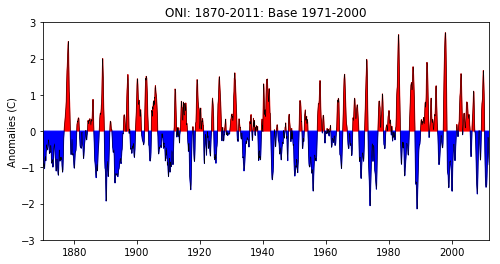

In [37]:
#*********************************
# plot graph
#*********************************
yrfrac = xAnom_avg['time.year'] + (xAnom_avg['time.month']/12)  # yyyymm_to_yyyyfrac(yyyymm, 0.0)

fig, ax = plt.subplots(figsize=(8,4))

trYMinF          = -3.0           # min value on y-axis
trYMaxF          =  3.0           # max value on y-axis
tiMainString     = pltTitle                            
tiYAxisString    = "Anomalies (C)"    # y-axis label
ax.plot(yrfrac, xAnom_avg, 'k', linewidth=0.5)
ax.fill_between(yrfrac, xAnom_avg, where=xAnom_avg>=0, interpolate=True, color='red')
ax.fill_between(yrfrac, xAnom_avg, where=xAnom_avg<0, interpolate=True, color='blue')
ax.set_ylabel(tiYAxisString)
ax.set_ylim([trYMinF, trYMaxF])
ax.set_xlim([yrfrac.min(), yrfrac.max()])
ax.set_title(pltTitle)


In [78]:
from matplotlib.font_manager import FontProperties
# we'll use this to control the fonts in the Table.

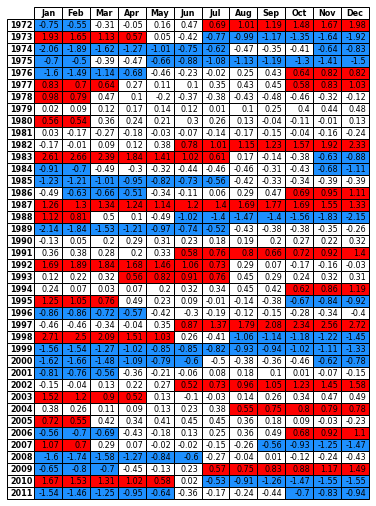

In [89]:
#*********************************
# plot table
#*********************************

#yrStrtTab = 1972
#yrLastTab = 2011
#nmos   = 12
#nyrs   = yrLastTab-yrStrtTab+1 # number of rows (nrows) 
#ncols  = nmos+1                # year and 12 monthly values
#nrc    = (/nyrs,ncols/)        # (/nrows,ncols/)
#tStrtTab = ind(yyyymm.eq.(yrStrtTab*100 + 1))
#tLastTab = ind(yyyymm.eq.(yrLastTab*100 +12))

data   = xAnom_avg.sel(time=slice('1972-01-01','2011-12-31'))
# reshape into years x months
data_reshape = np.reshape(data.values, (len(data)//12, 12))
# print(data_reshape)
# Colors
tabcol = []
for i, d in enumerate(data):
    if d <= -0.5:
        tabcol.append("dodgerblue")
    elif d >= 0.5:
        tabcol.append("r")
    else:
        tabcol.append("w")
tabcol = np.reshape(np.array(tabcol), (len(data)//12, 12))

months = ['Jan', 'Feb', 'Mar', "Apr", "May", 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

figTable, axTable = plt.subplots()
# Hide axes
axTable.xaxis.set_visible(False) 
axTable.yaxis.set_visible(False)
axTable.spines['top'].set_visible(False) 
axTable.spines['bottom'].set_visible(False)
axTable.spines['left'].set_visible(False) 
axTable.spines['right'].set_visible(False)
table = axTable.table(cellText=np.around(data_reshape, decimals=2), cellColours=tabcol, rowLabels=np.arange(1972,2011+1),
              loc='center', colLabels=months, fontsize=14)
# make bold labels
for (row, col), cell in table.get_celld().items():
    if (row == 0) or (col == -1):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))

# save PDF
# figTable.savefig("/Users/brianpm/Desktop/mpl_table.pdf", bbox_inches="tight", pad_inches=1)